### Classe Preditora de Demanda de Compartilhamento de Bikes
 

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [97]:
training = pd.read_csv("data/training.csv")
testing = pd.read_csv("data/testing.csv")
validation = pd.read_csv("data/validation.csv")

training.set_index('dteday', inplace=True)
testing.set_index('dteday', inplace=True)
validation.set_index('dteday', inplace=True)

In [98]:
training

,yr,hr,temp,hum,windspeed,cnt,cnt_lag_1,cnt_lag_2,season=1,season=2,...,mnth=10,mnth=11,mnth=12,weekday=0,weekday=1,weekday=2,weekday=3,weekday=4,weekday=5,weekday=6
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0,0,0.24,0.81,0.0000,16,40.0,32.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-01,0,1,0.22,0.80,0.0000,40,32.0,13.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-01,0,2,0.22,0.80,0.0000,32,13.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-01,0,3,0.24,0.75,0.0000,13,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-01,0,4,0.24,0.75,0.0000,1,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-01,1,19,0.40,0.50,0.1642,452,296.0,267.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-11-01,1,20,0.38,0.54,0.2537,296,267.0,202.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-11-01,1,21,0.38,0.54,0.1343,267,202.0,120.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [99]:
features = list(training.columns)
features.remove("cnt")
target = ["cnt"]

In [100]:
X_train, y_train = training[features], training[target]
X_test, y_test = testing[features], testing[target]
X_validation, y_validation = validation[features], validation[target]

In [101]:
model = RandomForestRegressor(max_depth=5, n_estimators = 6000, random_state=42)
model.fit(X_train, y_train)

/tmp/ipykernel_40023/3286370774.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


RandomForestRegressor(max_depth=5, n_estimators=6000, random_state=42)

In [103]:
train_pred = model.predict(X_train)
train_rmsle = np.sqrt(mean_squared_log_error(y_train, train_pred))

test_pred = model.predict(X_test)
test_rmsle = np.sqrt(mean_squared_log_error(y_test, test_pred))

In [104]:
train_rmsle

0.48309527122916324

In [106]:
test_rmsle

0.4128303838488372

In [108]:
training["pred"] = train_pred
train_tmp = training.groupby(["dteday"]).agg({"cnt":"sum","pred":"sum"}).reset_index()
traintmp_rmsle = np.sqrt(mean_squared_log_error(train_tmp["cnt"], train_tmp["pred"]))

In [110]:
testing["pred"] = test_pred
test_tmp = testing.groupby(["dteday"]).agg({"cnt":"sum","pred":"sum"}).reset_index()
testtmp_rmsle = np.sqrt(mean_squared_log_error(test_tmp["cnt"], test_tmp["pred"]))

In [111]:
traintmp_rmsle

0.12383881340962734

In [112]:
testtmp_rmsle

0.0633189443884394

In [115]:
# Hyperparameter tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 7000, num = 200)]
# Number of features to consider at every split
max_features = ["auto", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 7, num = 4)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap
}

In [117]:
# Cross validate — time series split
tscv = TimeSeriesSplit(n_splits=5)

In [119]:
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = tscv, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: 

[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2045; total time=   8.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2045; total time=  14.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2045; total time=  19.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2045; total time=  29.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2045; total time=  34.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2250; total time=  21.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2250; total time=  34.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=6863; total time= 1.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2250; total time=  50.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2250; total time= 1.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=6863; total time= 2.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2250; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=6692; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=6179; total time=  27.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=6863; total time= 3.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=6692; total time= 2.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=6179; total time=  41.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=6179; total time=  53.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=6863; total time= 4.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=6179; total time= 1.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=6692; total time= 3.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=6179; total time= 1.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=5804; total time= 1.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=6863; total time= 5.8min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=6692; total time= 4.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=3070; total time=  53.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=5804; total time= 3.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=3070; total time= 1.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=6692; total time= 5.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=4232; total time= 1.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=3070; total time= 2.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=5804; total time= 4.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=4232; total time= 2.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=3070; total time= 3.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=2421; total time=  13.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=2421; total time=  17.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=2421; total time=  22.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=2421; total time=  26.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=2421; total time=  28.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1908; total time=   8.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1908; total time=  12.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1908; total time=  15.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=5804; total time= 6.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1908; total time=  18.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1088; total time=  14.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1908; total time=  22.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1088; total time=  22.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=3070; total time= 4.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1088; total time=  32.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1088; total time=  42.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=4232; total time= 3.8min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1088; total time=  56.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=5804; total time= 8.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=985; total time=  11.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5735; total time= 1.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=985; total time=  20.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=4232; total time= 5.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=985; total time=  32.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=883; total time=   5.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=883; total time=   9.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=985; total time=  40.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=883; total time=  13.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=883; total time=  16.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=985; total time=  52.2s
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=883; total time=  18.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5735; total time= 3.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=4232; total time= 6.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5769; total time= 1.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=3446; total time=  23.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5735; total time= 4.8min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=3446; total time=  39.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5769; total time= 3.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=3446; total time=  52.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=985; total time=  12.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=3446; total time= 1.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=985; total time=  21.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5735; total time= 6.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=985; total time=  32.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=3446; total time= 1.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=985; total time=  38.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5769; total time= 4.8min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=985; total time=  51.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=4368; total time=  54.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3104; total time=  30.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=4368; total time= 1.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3104; total time=  43.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5735; total time= 8.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=4368; total time= 2.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5769; total time= 6.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3104; total time= 1.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3104; total time= 1.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=5974; total time=  59.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=4368; total time= 3.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3104; total time= 1.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=5974; total time= 1.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=5769; total time= 8.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=4368; total time= 4.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=5974; total time= 2.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=5974; total time= 2.8min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5906; total time= 2.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=4744; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=5974; total time= 3.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5906; total time= 4.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1327; total time=   6.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1327; total time=   7.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=4744; total time= 2.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1327; total time=  10.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1327; total time=  12.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1327; total time=  13.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3992; total time=  42.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=4744; total time= 4.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3992; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5906; total time= 7.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=4744; total time= 5.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1942; total time=  24.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3992; total time= 2.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1942; total time=  40.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3992; total time= 2.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1942; total time=  56.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=883; total time=   5.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=883; total time=   6.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=883; total time=   7.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=883; total time=   8.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=883; total time=  13.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1942; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5940; total time=  24.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5940; total time=  31.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=3992; total time= 3.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5940; total time=  45.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1942; total time= 1.6min
[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5906; total time= 9.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=4949; total time=  23.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=4744; total time= 6.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5940; total time=  57.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=4949; total time=  33.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5940; total time= 1.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=4949; total time=  45.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=4949; total time=  54.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=4949; total time= 1.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=3377; total time=  23.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5974; total time= 1.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=3377; total time=  37.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=3377; total time=  47.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=3377; total time= 1.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=6897; total time=  34.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5906; total time=12.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5974; total time= 2.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=3377; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=6897; total time=  45.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2933; total time=  18.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=6897; total time=  58.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2933; total time=  30.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=6897; total time= 1.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2933; total time=  42.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=6897; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2455; total time=  33.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5974; total time= 4.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2933; total time=  59.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2933; total time= 1.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2455; total time= 1.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2181; total time=  51.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2455; total time= 1.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5974; total time= 5.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2455; total time= 2.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2181; total time= 1.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2455; total time= 2.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=5052; total time= 1.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5974; total time= 6.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1327; total time=   7.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1327; total time=  10.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2181; total time= 2.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1327; total time=  14.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1327; total time=  19.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1327; total time=  21.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1259; total time=  16.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1259; total time=  32.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=5052; total time= 2.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2181; total time= 3.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1259; total time=  48.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=5223; total time=  24.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=5223; total time=  30.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1259; total time= 1.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=5223; total time=  37.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=5052; total time= 3.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=2181; total time= 4.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1259; total time= 1.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=5223; total time=  43.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=5223; total time=  51.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=5052; total time= 4.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5359; total time= 2.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=5052; total time= 5.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=6419; total time= 2.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5359; total time= 4.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=6658; total time= 1.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=6419; total time= 4.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5359; total time= 6.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=6658; total time= 1.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=6658; total time= 2.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5359; total time= 8.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=4232; total time=  57.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=6419; total time= 7.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=6658; total time= 3.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=4232; total time= 1.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=370; total time=   1.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=370; total time=   2.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=370; total time=   2.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=6658; total time= 4.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=370; total time=   3.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=370; total time=   3.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1635; total time=   7.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1635; total time=  10.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5359; total time=10.8min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1635; total time=  12.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1635; total time=  15.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=3582; total time=  13.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1635; total time=  19.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=3582; total time=  17.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=3582; total time=  20.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=3582; total time=  27.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4232; total time=  18.7s
[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=3582; total time=  28.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=4232; total time= 2.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4232; total time=  31.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=6419; total time= 9.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4232; total time=  39.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2489; total time=  20.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4232; total time=  49.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=4232; total time= 3.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2489; total time=  32.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=4232; total time= 1.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=4027; total time=  13.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2489; total time=  47.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=4027; total time=  19.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=4027; total time=  26.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2489; total time= 1.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=4027; total time=  32.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=4232; total time= 4.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=4027; total time=  38.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=2489; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5530; total time=  22.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5530; total time=  26.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5530; total time=  37.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=6419; total time=12.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=6829; total time= 1.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5530; total time=  49.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=3275; total time=  36.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=5530; total time=  55.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=3275; total time= 1.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1498; total time=  19.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=3275; total time= 1.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=6829; total time= 3.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1498; total time=  37.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1498; total time=  54.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=3275; total time= 2.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2386; total time=  16.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1498; total time= 1.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2386; total time=  25.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=3275; total time= 2.8min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2386; total time=  34.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1498; total time= 1.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2386; total time=  43.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=6829; total time= 5.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=2386; total time=  54.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=3685; total time=  41.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=3685; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=3685; total time= 1.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=6248; total time= 1.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=6829; total time= 7.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1122; total time=   6.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=3685; total time= 2.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1122; total time=   8.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1122; total time=   9.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1122; total time=  14.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=1122; total time=  13.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=3685; total time= 3.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=6248; total time= 3.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=6760; total time= 1.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=6829; total time= 9.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=5496; total time=  28.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=6760; total time= 2.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=5496; total time=  43.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=6248; total time= 5.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=5496; total time=  59.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2011; total time=  13.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=5496; total time= 1.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2011; total time=  16.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2011; total time=  20.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2011; total time=  26.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=6760; total time= 4.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=5496; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=2011; total time=  28.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1327; total time=  18.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1327; total time=  32.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1327; total time=   8.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1327; total time=  11.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1327; total time=  49.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1327; total time=  14.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1327; total time=  16.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1327; total time= 1.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=746; total time=  12.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=6248; total time= 7.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1327; total time=  19.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1327; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=746; total time=  27.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=6760; total time= 5.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=3514; total time=  19.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=746; total time=  39.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=3514; total time=  28.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=746; total time=  51.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=610; total time=   3.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=610; total time=   4.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=610; total time=   5.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=610; total time=   5.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=610; total time=   6.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=3514; total time=  40.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=746; total time= 1.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1054; total time=   5.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1054; total time=   9.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1054; total time=  12.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=3514; total time=  44.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1054; total time=  14.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=1054; total time=  18.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=3514; total time=  57.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=849; total time=  12.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=6248; total time= 9.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=6760; total time= 6.8min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=849; total time=  30.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=849; total time=  44.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=4949; total time= 1.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=849; total time=  58.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=2591; total time=  45.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=849; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=2591; total time= 1.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=3036; total time=  14.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=4949; total time= 3.8min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=3036; total time=  24.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=2591; total time= 2.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=3036; total time=  34.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=3036; total time=  44.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=3036; total time=  50.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2045; total time=  41.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=2591; total time= 2.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=4949; total time= 5.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=2591; total time= 3.8min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2045; total time= 1.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=6589; total time= 1.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2045; total time= 2.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=4949; total time= 8.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2045; total time= 3.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=6589; total time= 2.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4710; total time=  31.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4710; total time=  50.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2045; total time= 4.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=6589; total time= 3.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4710; total time= 1.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=5633; total time=  20.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=4949; total time= 9.8min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=5633; total time=  34.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4710; total time= 1.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=5633; total time=  39.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=405; total time=   7.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=405; total time=  15.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=405; total time=  17.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=5633; total time=  53.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=405; total time=  28.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1088; total time=  14.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=5633; total time=  57.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1088; total time=  24.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=4710; total time= 1.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=405; total time=  34.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=6589; total time= 4.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1088; total time=  40.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1088; total time=  51.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5018; total time=  52.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5393; total time=  23.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1088; total time= 1.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5393; total time=  33.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5393; total time=  38.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5018; total time= 1.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5393; total time=  47.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=6589; total time= 5.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=5393; total time=  52.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5018; total time= 2.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=4676; total time= 1.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=6521; total time= 1.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5018; total time= 3.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5018; total time= 4.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=4676; total time= 3.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=6521; total time= 1.8min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5086; total time=  52.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=6521; total time= 2.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5086; total time= 1.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=6521; total time= 3.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=4676; total time= 5.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=4949; total time=  23.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=4949; total time=  40.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=4949; total time=  53.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5086; total time= 2.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=6521; total time= 4.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2147; total time=  25.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=4949; total time= 1.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5086; total time= 3.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2147; total time=  50.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=4676; total time= 7.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=917; total time=   7.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=4949; total time= 1.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=917; total time=  12.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=917; total time=  17.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=917; total time=  22.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=917; total time=  27.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2147; total time= 1.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2011; total time=  29.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=5086; total time= 3.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=370; total time=   6.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2147; total time= 1.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2011; total time=  56.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=370; total time=  10.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=370; total time=  15.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=780; total time=   4.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=780; total time=   6.5s
[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=370; total time=  21.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=4676; total time= 9.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=370; total time=  26.2s
[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=780; total time=   8.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2011; total time= 1.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=780; total time=   9.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=2147; total time= 2.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1122; total time=   4.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1122; total time=   6.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1122; total time=   8.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=780; total time=  12.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1122; total time=  11.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=1122; total time=  13.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=3343; total time=  16.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2011; total time= 1.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=3343; total time=  21.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=3343; total time=  26.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2011; total time= 2.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=6658; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=3343; total time=  33.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=3343; total time=  38.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6692; total time=  36.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6692; total time=  54.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=6658; total time= 2.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2694; total time=  12.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6692; total time= 1.1min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2694; total time=  15.6s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2694; total time=  20.0s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2762; total time=  12.0s
[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2694; total time=  23.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=2694; total time=  27.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6692; total time= 1.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2762; total time=  16.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2762; total time=  18.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=6658; total time= 3.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2762; total time=  24.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=6692; total time= 1.8min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2762; total time=  26.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5701; total time=  46.2s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=3514; total time=  32.3s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5701; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=6658; total time= 4.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=3514; total time=  59.4s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5701; total time= 1.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=3514; total time= 1.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=6658; total time= 5.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5701; total time= 2.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=3514; total time= 1.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=5701; total time= 3.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5564; total time= 1.9min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=3514; total time= 2.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=6863; total time=  54.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=6863; total time= 1.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5564; total time= 3.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=6863; total time= 2.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=4778; total time= 1.2min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=6863; total time= 2.8min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=3, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=6863; total time= 3.5min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1190; total time=  14.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5564; total time= 5.7min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=4778; total time= 2.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1190; total time=  25.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1190; total time=  35.7s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1190; total time=  47.9s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=6145; total time=  34.1s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=4778; total time= 3.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1190; total time= 1.0min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=6145; total time=  54.5s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5564; total time= 7.6min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1942; total time=  37.8s


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=4778; total time= 4.4min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=6145; total time= 1.3min


/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=6145; total time= 1.7min
[CV] END bootstrap=False, max_depth=7, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=6145; total time= 2.0min
[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1942; total time= 1.2min
[CV] END bootstrap=True, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=4778; total time= 5.3min
[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=5564; total time= 9.2min
[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1942; total time= 1.6min
[CV] END bootstrap=False, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1942; total time= 1.9min
[CV] END bootstrap=False, max_depth=7, max

/home/shazam/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 4, 5, 7],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 234, 268, 302,
                                                         336, 370, 405, 439,
                                                         473, 507, 541, 575,
                                                         610, 644, 678, 712,
                                                         746, 780, 815, 849,
                                                         883, 917, 951, 985,
             

In [120]:
# Best parameters
rf_random.best_params_
"""
'n_estimators': 746,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 7,
 'bootstrap': True
"""

{'n_estimators': 746,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 7,
 'bootstrap': True}

In [121]:
model = RandomForestRegressor(max_depth=7, n_estimators = 746, min_samples_split=5,min_samples_leaf=1, max_features='auto',random_state=42, bootstrap=True)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
train_rmsle = np.sqrt(mean_squared_log_error(y_train, train_pred))

test_pred = model.predict(X_test)
test_rmsle = np.sqrt(mean_squared_log_error(y_test, test_pred))

/tmp/ipykernel_40023/4112021897.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [122]:
print(train_rmsle)
print(test_rmsle)

0.3486833815199401
0.3179063635117024


#### RMSLE Comparison

##### Previous Run
- Training Data: 0.48309527122916324
- Testing Data:0.4128303838488372

##### Current Run
- Training Data: 0.3486833815199401
- Testing Data: 0.3179063635117024

In [124]:
training["pred"] = train_pred
train_tmp = training.groupby(["dteday"]).agg({"cnt":"sum","pred":"sum"}).reset_index()
traintmp_rmsle = np.sqrt(mean_squared_log_error(train_tmp["cnt"], train_tmp["pred"]))

testing["pred"] = test_pred
test_tmp = testing.groupby(["dteday"]).agg({"cnt":"sum","pred":"sum"}).reset_index()
testtmp_rmsle = np.sqrt(mean_squared_log_error(test_tmp["cnt"], test_tmp["pred"]))

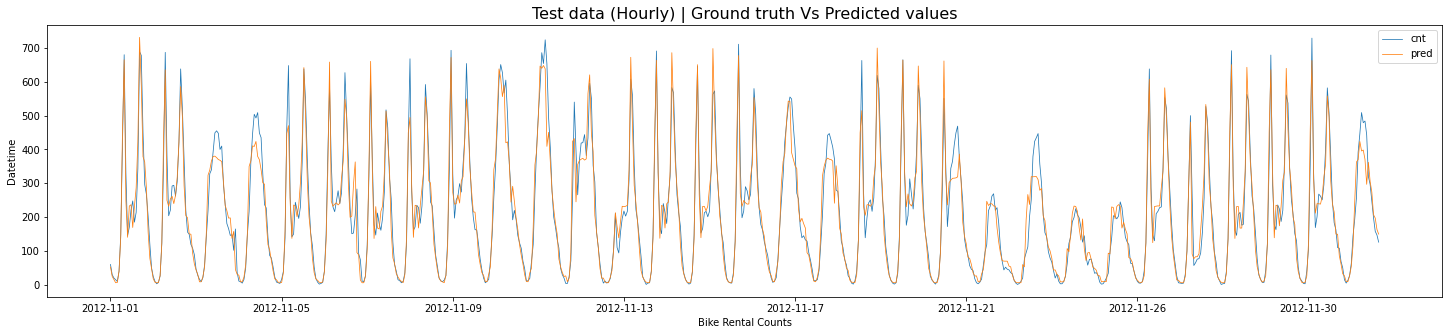

In [141]:
fig, ax = plt.subplots(figsize=(25, 5))
testing["cnt"].plot(linewidth=0.75, ax=ax)
testing["pred"].plot(linewidth=0.75, ax=ax)
ax.set_xlabel("Bike Rental Counts")
ax.set_ylabel("Datetime")
ax.set_title("Test data (Hourly) | Ground truth Vs Predicted values", fontsize=16)
ax.legend(loc='best')
fig.savefig(f"regression/Test Data (Daily).png")

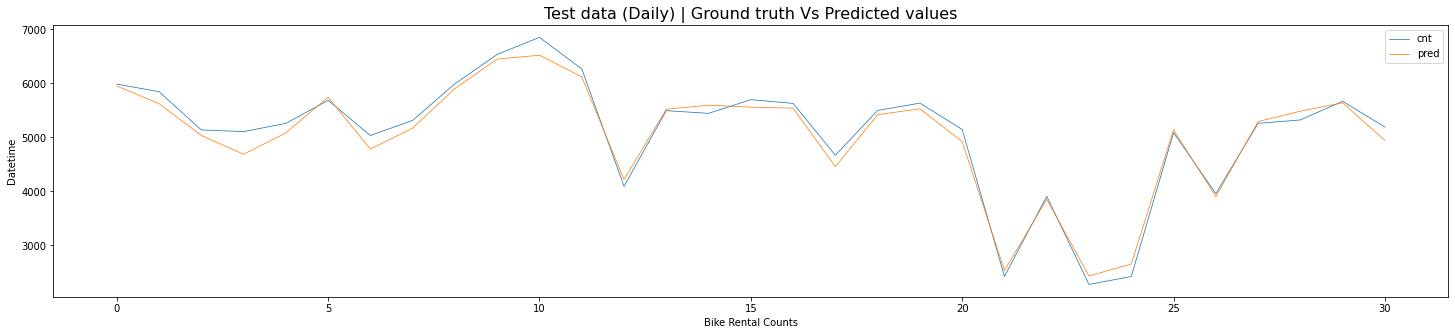

In [142]:
fig, ax = plt.subplots(figsize=(25, 5))
test_tmp["cnt"].plot(linewidth=0.75, ax=ax)
test_tmp["pred"].plot(linewidth=0.75, ax=ax)
ax.set_xlabel("Bike Rental Counts")
ax.set_ylabel("Datetime")
ax.set_title("Test data (Daily) | Ground truth Vs Predicted values", fontsize=16)
ax.legend(loc='best')
fig.savefig(f"regression/Test Data (Daily).png")

In [146]:
import pickle
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))

In [147]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9299775742192237


In [148]:
result = loaded_model.score(X_validation, y_validation)
print(result)

0.9425828404720789
